In [76]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [77]:
# read in the data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print("Shape of train set:", train_df.shape)
print("Shape of test set:", test_df.shape)
train_df.head()

Shape of train set: (4209, 378)
Shape of test set: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


There are 378 columns. The first column is ID. The second row is y. The rest 376 columns are features.

# analyze value y

In [78]:
train_y = train_df['y'].values    # .values can make train_y from pandas frame into numpy array
train_y

array([ 130.81,   88.53,   76.26, ...,  109.22,   87.48,  110.85])


Now we'd like to see if there is any outliers


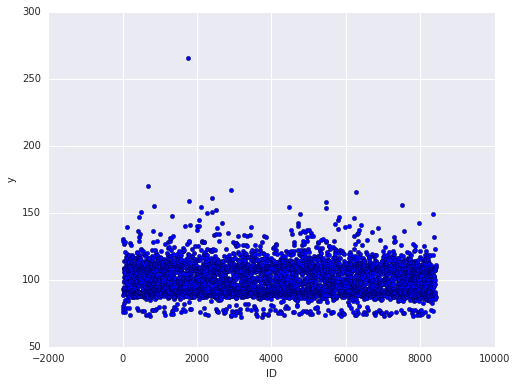

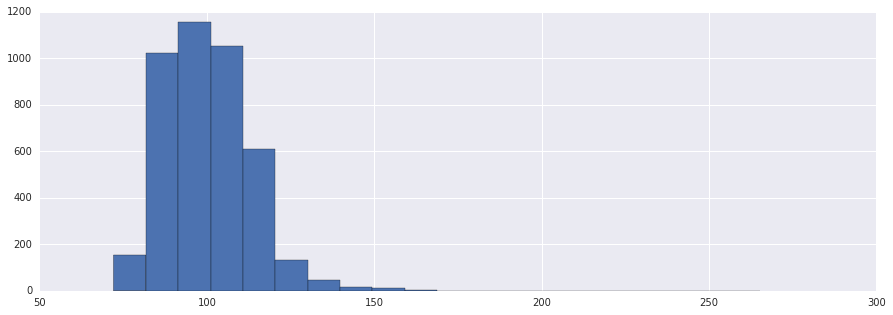

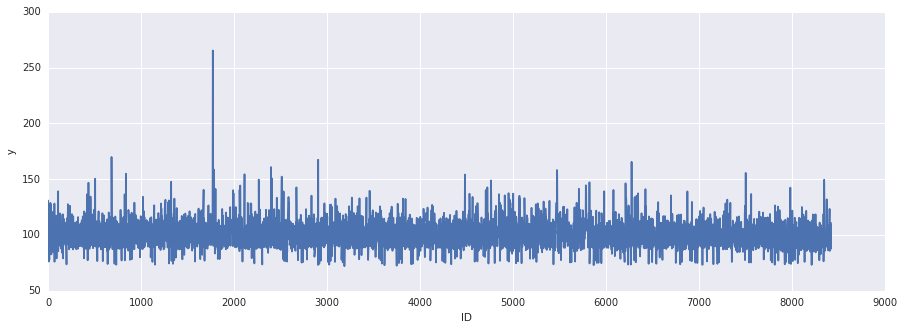

In [79]:
plt.figure(figsize=(8,6))
plt.scatter(train_df['ID'], train_df['y'])
plt.xlabel('ID')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(train_y, bins=20)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(train_df['ID'], train_df['y'])
plt.xlabel('ID')
plt.ylabel('y')
plt.show()

It seems that there is an outlier whose y is larger than 250. So we just filter the outlier and look into the distribution of the y value.

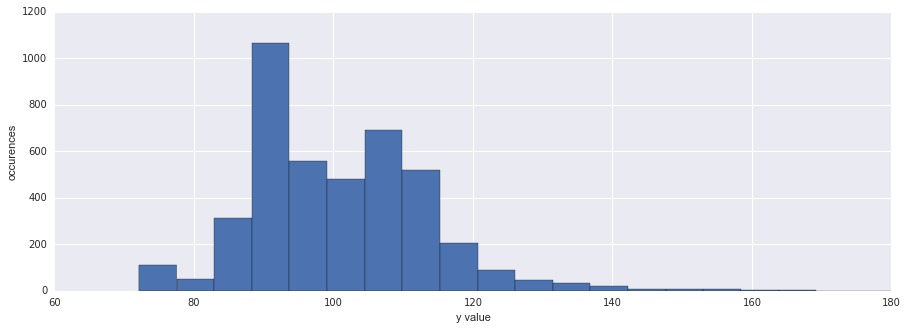

In [73]:
ultimate = 180
train_df['y'].ix[train_df['y'] > ultimate] = ultimate

plt.figure(figsize=(15, 5))
plt.hist(train_y, bins=20)
plt.xlabel('y value')
plt.ylabel('occurences')
plt.show()

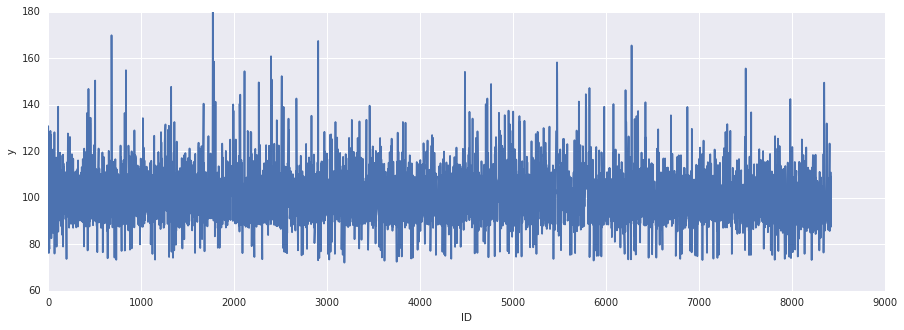

In [75]:
plt.figure(figsize=(15,5))
plt.plot(train_df['ID'], train_df['y'])
plt.xlabel('ID')
plt.ylabel('y')
plt.show()

# Feature analysis

## column types
Firstly, we can analysis the type of all columns

In [80]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column type']
dtype_df.groupby('Column type').aggregate('count').reset_index()

,Column type,Count
0,int64,369
1,float64,1
2,object,8


There are 8 objects which are X0, X1, X2, X3, X4, X5, X6, X8. And a float column which is y.

## missing values

In [81]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


It seem that there's no missing value in the dataset.

## Integer columns

In [82]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ['ID', 'y', 'X0', 'X1', 'X2','X3','X4','X5','X6','X8']:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

# Xgboost starter

In [123]:
usable_columns = list(set(train_df.columns) - set(['ID', 'y']))
y_train = train_df['y'].values
id_test = test_df['ID'].values

x_train = train_df[usable_columns]
x_test = test_df[usable_columns]

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
        
x_train.head()


,X266,X47,X212,X125,X305,X130,X250,X311,X248,X136,...,X68,X280,X169,X286,X314,X80,X147,X326,X138,X231
0,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,1,1,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [124]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)





[0]	train-rmse:99.1397	valid-rmse:98.2538	train-r2:-58.3426	valid-r2:-67.6247
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.1832	valid-rmse:80.2714	train-r2:-38.7928	valid-r2:-44.804
[20]	train-rmse:66.541	valid-rmse:65.5967	train-r2:-25.7332	valid-r2:-29.5876
[30]	train-rmse:54.6149	valid-rmse:53.6305	train-r2:-17.0092	valid-r2:-19.4459
[40]	train-rmse:44.9172	valid-rmse:43.8842	train-r2:-11.1814	valid-r2:-12.6899
[50]	train-rmse:37.0508	valid-rmse:35.9587	train-r2:-7.28831	valid-r2:-8.19158
[60]	train-rmse:30.6913	valid-rmse:29.5289	train-r2:-4.68723	valid-r2:-5.19837
[70]	train-rmse:25.5745	valid-rmse:24.3342	train-r2:-2.949	valid-r2:-3.20936
[80]	train-rmse:21.4844	valid-rmse:20.1622	train-r2:-1.78687	valid-r2:-1.88973
[90]	train-rmse:18.2427	valid-rmse:16.8438	train-r2:-1.00933	valid-r2:-1.01679
[100]	train-rmse:15.7022	valid-rmse:14.2284	train-r2:-0.488656	valid-r2:-0

In [125]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('./result/xgb_depth_4.csv', index=False)
sub.head()


,ID,y
0,1,89.319649
1,2,104.898849
2,3,89.684471
3,4,77.551781
4,5,111.189957
